<a href="https://colab.research.google.com/github/rumijay/Data-Science-2025/blob/main/Rumi_Unit6ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:


import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import graphviz as gv
import matplotlib.pyplot as plt
import seaborn as sns


# Unit 6 Exercises: Is my model good?

#### Over and Under fitting, Model Visualization, and Model/Variable Selection Concepts

These exercises are meant to get you to think about the model and variable selection process, and consider how we determine if a model is "good".

**Task1**:

Does elpd_loo mean anything if we only have one model?

yes,it has meaning for a single model, but its value is relative and is primarily used as a diagnostic or for comparison against other models.

**Task2**:

Describe overfitting, in the context of this course

verfitting is when a model learns its training data too well, capturing noise and random fluctuations instead of the true underlying patterns

**Task3**:

How do we mitigate overfitting?

you can collect more data and reduce model complexity.

**Task4**:

How do we mitigate underfitting?

add more parameters


**Task5**:

Why would we want more than one predictor in a model?

 to capture the real-world complexity where outcomes are influenced by many factors

**Task6**:

Can we have too many predictors? How would we know?

Yes, you can have too many predictors, leading to overfitting,

**Task7**:

What is variable selection, and how does it work?

 the process of choosing the most relevant subset of predictor variables for a statistical model

**Task8**:

Describe the differences and similarities between the following three models: linear regression with two predictors, one of which is a categorical variable:

- adding the variables in the model, as is standard.
- using that categorical variable as a hierarchy upon the other predictor variable.
- adding the variables, plus the categorical variable's interaction with the other variable.

All three are multiple linear regression models used to predict a continuous outcome variable from the same set of two input variables (one continuous, one categorical).
All assume a linear relationship between the predictors (or their transformed

**Task9**:

How do we visualize multiple linear regression models? Can we visualize the entire model, all at once?

You can visualize multiple linear regression by plotting each predictor against the response

**Task10**:

Compare the following linear models that all use the basketball data to predict field goal percentage:

- predictors free throw percentage and position (with position as a categorical predictor)
- predictors free throw percentage and position (with position as a hierarchy)
- predictors free throw percentage and position (with position interacting with frew throw percentage)
- predictors free throw percentage, position, 3 point attempts, and interactions between all three predictors
- predictors free throw percentage, position, 3 point attempts, with an interaction between 3 point attempts and postion.

using ```az.compare()``` and ```az.plot_compare()```, or an equivalent method using LOO (elpd_loo).

You may use the following two code blocks to load and clean the data.

In [2]:
import pandas as pd
#have to drop incomplete rows, so that bambi will run
bb = pd.read_csv(
    'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv'
    ).dropna()

In [3]:
#only look at players who played more than 600 minutes
#which is 20 min per game, for 30 games
bb = bb.query('MP > 600')
#remove players who never missed a free throw
bb = bb.query('`FT%` != 1.0')
#filter out the combo positions. This will make it easier to read the graphs
bb = bb.query("Pos in ['C','PF','SF','SG','PG']")
#gets rid of the annoying '%' sign
bb.rename(columns={"FT%":"FTp","FG%":"FGp"}, inplace=True)

In [ ]:
!pip install bambi

In [6]:
import bambi as bmb

In [ ]:
model_basketball = bmb.Model("`FGp` ~ `FTp` + Pos", data=bb)
idata_basketball = model_basketball.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
model_basketball_h = bmb.Model("`FGp` ~ (`FTp`|Pos)", data=bb)
idata_basketball_h = model_basketball_h.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
model_bb_inter = bmb.Model("`FGp` ~ `FTp` + Pos + `FTp`:Pos", data=bb)
idata_bb_inter = model_bb_inter.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
model_bb_interq = bmb.Model("`FGp` ~ `FTp` + `3PA` + `FTp`:`3PA`", data=bb)
idata_bb_interq = model_bb_interq.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
ft_pos_3pt_inter2 = bmb.Model("`FGp` ~ `FTp` + Pos + `3PA` + Pos:`3PA`", data=bb).fit(idata_kwargs={"log_likelihood":True})

In [ ]:
cmp_df = az.compare({ #used gemini on this part
    "FTp_Pos": idata_basketball,
    "FTp_Pos_hierarchy": idata_basketball_h,
    "FTp_Pos_interaction": idata_bb_inter,
    "FTp_3PA_interaction_no_Pos": idata_bb_interq,
    "FTp_Pos_3PA_Pos_3PA_interaction": ft_pos_3pt_inter2
})


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

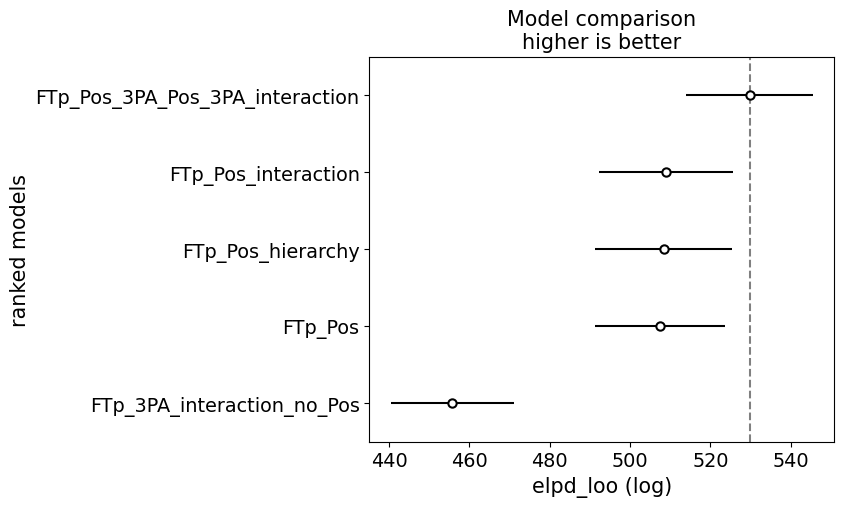

In [19]:
az.plot_compare(cmp_df)

**Task11**:

Which model is "better" according to this metric?

Why do you think that is?

Model 5, because it had a higher value making it more accurate

**Task12:**

The body data set has a measure of body fat percentage (siri), as well as several other measurments of other parts of a person's body, plus their age.

Create a sensible causal diagram for this set of variables.

Based on your causal diagram, which variable should you try to predict? Why?

In [14]:
body = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/body_fat.csv')

In [20]:
body.head()

,siri,age,weight,height,abdomen,thigh,wrist
0,12.3,23,70.1,172,85.2,59.0,17.1
1,6.1,22,78.8,184,83.0,58.7,18.2
2,25.3,22,70.0,168,87.9,59.6,16.6
3,10.4,26,84.0,184,86.4,60.1,18.2
4,28.7,24,83.8,181,100.0,63.2,17.7


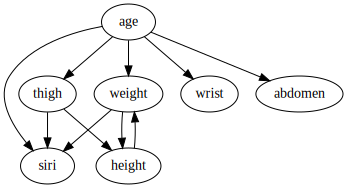

In [26]:

b_dag = gv.Digraph(name="Body")


b_dag.node('S','siri')
b_dag.node('A','age')
b_dag.node('W','weight')
b_dag.node('H','height')
b_dag.node('D','wrist')
b_dag.node('T','thigh')
b_dag.node('R','abdomen')
b_dag.edges(['AS','AW','WS','AD','AT','TS','TH','AR','HW','WH'])

b_dag


siri because it had the most predictors